# Performance Profiling

In this notebook, we analyze the output from log files created from `performance_profiling_tsm.py`. This:
1. baseline (current state of the code)


For each we do a `basic profile` and `detailed profile`:
* `basic`: tests 1, 10, 1000, 10000, and 100000 iterations with combinations of 1, 1000, and 10000 length xarrays
* `detailed`: tests one specific profile (if timed out)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Baseline

### Basic Profile

I ran the basic profile overnight, and it basically "timed out" at the 10,000 iteration; 10,000 cell scenario. Let's analyze those results:

In [2]:
bs = pd.read_csv(
    '../temp/performance_profiling/baseline_gridsizes.log'
)
bs

,2024-02-22 22:01:43,872,INFO,iters,gridsize,avg_increment_time,total_increment_time
0,2024-02-22 22:02:01,750,INFO,1,1,17.780313,17.878224
1,2024-02-22 22:02:17,537,INFO,1,1000,15.619797,15.785200
2,2024-02-22 22:02:18,59,INFO,1,10000,0.414088,0.521492
3,2024-02-22 22:02:18,988,INFO,10,1,0.075021,0.928926
4,2024-02-22 22:02:19,636,INFO,10,1000,0.053721,0.647442
5,2024-02-22 22:02:20,618,INFO,10,10000,0.083003,0.982176
6,2024-02-22 22:02:25,774,INFO,100,1,0.050012,5.155724
7,2024-02-22 22:02:30,337,INFO,100,1000,0.044690,4.546547
8,2024-02-22 22:02:38,751,INFO,100,10000,0.082943,8.414162
9,2024-02-22 22:03:13,65,INFO,1000,1,0.034112,34.313102


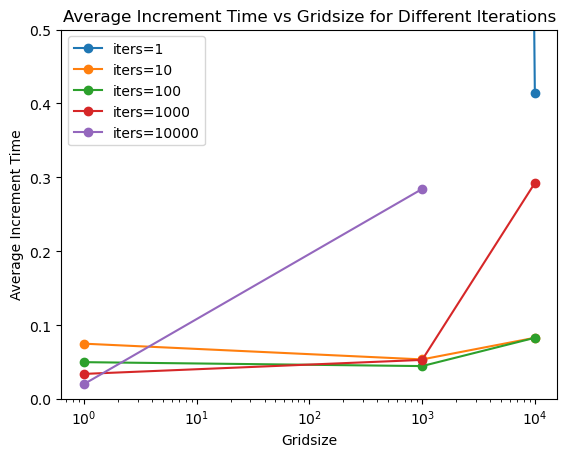

In [4]:
df = bs
# Grouping by 'iters' and plotting
fig, ax = plt.subplots()

for key, grp in df.groupby('iters'):
    ax.plot(grp['gridsize'], grp['avg_increment_time'], marker='o', linestyle='-', label=f'iters={key}')

ax.set_xscale('log')
ax.set_ylim(0,0.5)
ax.legend()
ax.set_xlabel('Gridsize')
ax.set_ylabel('Average Increment Time')
ax.set_title('Average Increment Time vs Gridsize for Different Iterations')

plt.show()

With a grid size of just one cell, we see that the largest number of iterations is actually fastest, I think due to the `numba` / no-numba discussion. However, as the grid size increases, we see there are points at which the time per increment really takes off. 10,000 iterations and 1,000 cells takes about as much time per timestep as 10,000 grid cells at 1,000 timesteps; beyond this, the testing script was aborted because it had been running the entire night without output -- >12 hours for <100,000 timesteps is AT LEAST 0.432 seconds/timestep.

`iters=1` is slowest per timestep, I think due to the compilation step at the beginning that has some expense. 

## Detailed Profiling

Now, we dive into the point at which this failed. We run the log output of just the 10,000 iteration and 10,000 cell test case for our more detailed profiling, which calculates the seconds per iteration at every 100 timesteps to get a better sense of what is going on. This ran all day and did not complete, but we can plot the results to get a sense of where we're failing:

In [9]:
bs_detailed = pd.read_csv(
    '../temp/performance_profiling/baseline_10000_10000_detailed_profile.log'
)
bs_detailed

,2024-02-23 09:44:06,538,INFO,timestep,MB,time_per_iter
0,2024-02-23 09:44:25,42,INFO,100,197.940408,0.184442
1,2024-02-23 09:44:42,155,INFO,200,389.940808,0.171134
2,2024-02-23 09:45:06,811,INFO,300,581.941208,0.246557
3,2024-02-23 09:45:34,771,INFO,400,773.941608,0.279599
4,2024-02-23 09:46:09,324,INFO,500,965.942008,0.345536
...,...,...,...,...,...,...
64,2024-02-23 14:44:01,265,INFO,6500,12485.966008,5.004906
65,2024-02-23 15:02:13,643,INFO,6600,12677.966408,10.923542
66,2024-02-23 15:48:13,83,INFO,6700,12869.966808,27.593644
67,2024-02-23 16:24:55,606,INFO,6800,13061.967208,22.024890


C:\Users\sjordan\AppData\Local\Temp\ipykernel_29140\1862149701.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(bs_detailed.timestep, bs_detailed.time_per_iter, 'b-', marker='o', linestyle='-',)
C:\Users\sjordan\AppData\Local\Temp\ipykernel_29140\1862149701.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(bs_detailed.timestep, bs_detailed.MB, 'r-', marker='o', linestyle='-',)


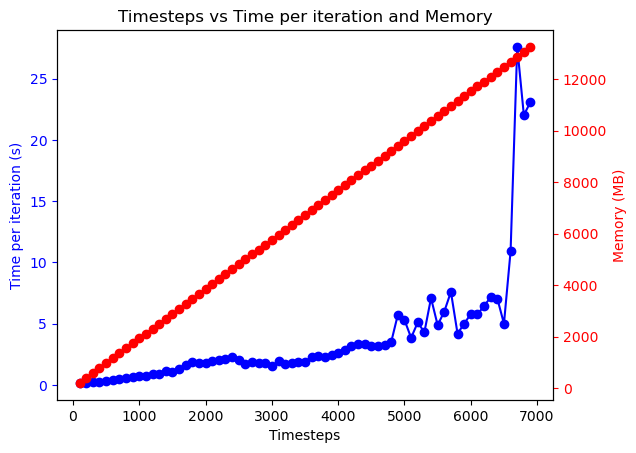

In [12]:
fig, ax1 = plt.subplots()

# Plot timesteps vs time_per_iter on the first y-axis
ax1.plot(bs_detailed.timestep, bs_detailed.time_per_iter, 'b-', marker='o', linestyle='-',)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Time per iteration (s)', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis and plot MB on it
ax2 = ax1.twinx()
ax2.plot(bs_detailed.timestep, bs_detailed.MB, 'r-', marker='o', linestyle='-',)
ax2.set_ylabel('Memory (MB)', color='r')
ax2.tick_params('y', colors='r')

plt.title('Timesteps vs Time per iteration and Memory')
plt.show()

The first thing we can see is that there's a massive spike in time per iteration as we approach 7,000 iterations. Memory steadily increases with each timestep, increasing from 0 MB to 12,000 MB (12 GB).  